# A simple 2D MeanFlow model

This notebook trains and evaluates a simple 2D MeanFlow model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard

Model (velocity): MLP

## Imports and init device

In [1]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm


# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
if torch.cuda.is_available():
    device = 'cuda:6'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [3]:
torch.manual_seed(42)

## Dataset

In [4]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45

    return data.float()

## Model

In [10]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim + 2*time_dim, hidden_dim),
            Swish(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                Swish(),
            ) for _ in range(6)],
            nn.Linear(hidden_dim, input_dim),
            )

    def forward(self, x: Tensor, r: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()
        r = r.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        r = r.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, r, t], dim=1)
        output = self.main(h)

        return output.reshape(*sz)

## Train MeanFlow model

In [ ]:
# training arguments
lr = 3e-4
batch_size = 4096
iterations = 40001
print_every = 2000
hidden_dim = 1024

# average velocity field model init
avf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
# avf = torch.nn.DataParallel(avf, device_ids=list(range(torch.cuda.device_count())))

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(avf.parameters(), lr=lr)

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad()

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = q(X_1)N(X_0|0,I)
    x_0 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    x_1 = torch.randn_like(x_0).to(device)

    # sample two time points from a logit-normal distribution
    r = torch.sigmoid(torch.randn(x_1.shape[0], device=device) - 0.4)
    t = torch.sigmoid(torch.randn(x_1.shape[0], device=device) - 0.4) # mean -0.4, var 1

    # set r = t for 75% of the batch
    mask = torch.randperm(batch_size)[int(batch_size * 0.75)]
    r[mask] = t[mask]

    # ensure r <= t
    mask = r > t
    r[mask], t[mask] = t[mask], r[mask]

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    x_t = path_sample.x_t
    dx_t = path_sample.dx_t

    # predict average velocity
    v, dv_t = torch.func.jvp(avf, (x_t, r, t), (dx_t, torch.zeros_like(r), torch.ones_like(t)))

    # target average velocity
    v_tgt = dx_t - (t - r).unsqueeze(1) * dv_t

    # mean flow l2 loss
    loss = torch.pow(avf(x_t, r, t) - v_tgt.detach(), 2).mean()
    
    # optimizer step
    (loss / (loss.detach() + 1e-8)).backward() # backward pass with adaptive loss weighting
    torch.nn.utils.clip_grad_norm_(avf.parameters(), max_norm=1.0)  # gradient clipping
    optim.step() # update

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

#### Sample from trained model

In [13]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, r: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, r, t)

wrapped_avf = WrappedModel(avf)

In [34]:
norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_gen = x_init - wrapped_avf(x_init, torch.zeros(batch_size, device=device), torch.ones(batch_size, device=device)).detach() # sample from the model
sol = torch.stack([x_init, x_gen], dim=0)

### Visualize the path

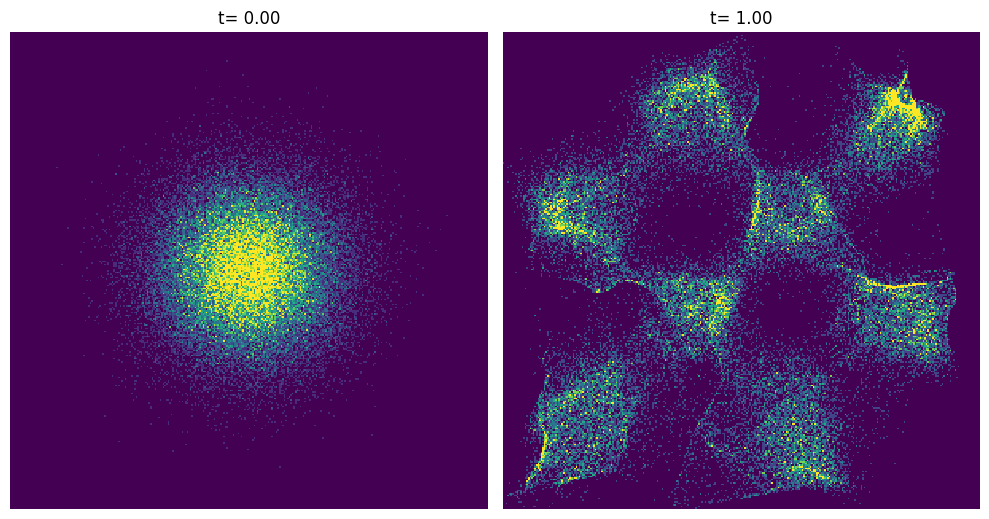

In [36]:
sol = sol.cpu().numpy()
T = [0, 1]

fig, axs = plt.subplots(1, 2,figsize=(10,10))

for i in range(2):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()